In [3]:
import illustrisAPI.data as iApi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#example of getting subhalo data from z=1 in illustris 3
haloFirstSub=iApi.getHaloField('GroupFirstSub',snapshot=85,simulation='Illustris-3')
haloMass=iApi.getHaloField('GroupMass',snapshot=85,simulation='Illustris-3')
subVelDisp=iApi.getSubhaloField('SubhaloVelDisp',snapshot=85,simulation='Illustris-3')
subBhMass=iApi.getSubhaloField('SubhaloBHMass',snapshot=85,simulation='Illustris-3')

/Users/Zephyr/Astro/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:103: RuntimeWarning: divide by zero encountered in log
  return np.divide(np.log(a, out=a), np.log(self.base), out=a)


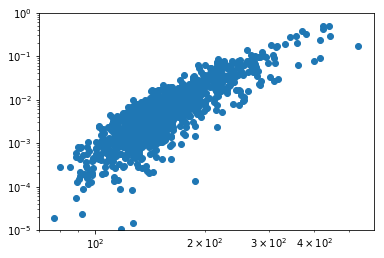

In [5]:
#example plots of stellar component of the black hole sigma relation for central galaxies
bigGalaxies=np.argwhere(haloMass>100)
mSigma=plt.gca()
mSigma.scatter(subVelDisp[haloFirstSub[bigGalaxies]],subBhMass[haloFirstSub[bigGalaxies]])
mSigma.set_yscale('log')
mSigma.set_xscale('log')
mSigma.set_ylim(1e-5,1)
plt.show()

In [39]:
#example of getting data from a particular galaxy (from online)
fields=[
    [4,'Coordinates'],
    [4,'Velocities'],
    [4,'Masses']
]
data=iApi.getGalaxy(150,fields)
rStar=data[0][:,:]
vStar=data[1][:,:]
mStar=data[2][:]

/Users/Zephyr/Astro/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log


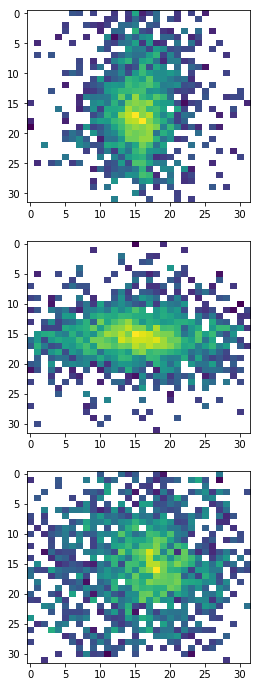

In [40]:
#example plots of stellar component of the galaxy
fig = plt.figure(figsize=(4,12))
grid=matplotlib.gridspec.GridSpec(3,1)
#moves to center of mass frame
com=findCenterMass(rStar,mStar)
rStar=rStar-com
vom=findCenterVelocity(vStar,mStar)
vStar=vStar-vom
#reorients with z-axis along direction of galaxy angular momentum
jUnit=findPlane(rStar,vStar)
rStar=projectPos(jUnit,rStar)
vStar=projectPos(jUnit,vStar)
#plot map of projected density
nPixels=32
edgeDist=10
plotMap(rStar,mStar,mStar,nPixels,edgeDist,grid,0,0,useMean=0,projection=0)
plotMap(rStar,mStar,mStar,nPixels,edgeDist,grid,0,1,useMean=0,projection=1)
plotMap(rStar,mStar,mStar,nPixels,edgeDist,grid,0,2,useMean=0)
plt.show()

In [15]:
# routines used for plotting and data handling in the examples
def findCenterMass(rStar,mStar):
    com=np.zeros(3)
    for i in range(3):
        com[i]=np.sum(rStar[:,i]*mStar[:])/np.sum(mStar[:])
    return com
def findCenterVelocity(vStar,mStar):
    vom=np.zeros(3)
    for i in range(3):
        vom[i]=np.sum(vStar[:,i]*mStar[:])/np.sum(mStar[:])
    return vom
def findPlane(rStar,vStar):
    jStar=np.cross(rStar,vStar)
    j=np.sum(jStar,axis=0)
    j=j/np.linalg.norm(j)
    return j
def projectPos(j,r):
    z=j[0]*r[:,0]+j[1]*r[:,1]+j[2]*r[:,2]
    n=np.array([0,-j[2],j[1]])
    n=n/np.linalg.norm(n)
    m=np.cross(j,n)
    x=n[0]*r[:,0]+n[1]*r[:,1]+n[2]*r[:,2]
    y=m[0]*r[:,0]+m[1]*r[:,1]+m[2]*r[:,2]
    return np.vstack((x,y,z)).T
def findMap(r,m,data,nPixels,edgeDist,mean=1,projectAxis=2):
    pixels=np.zeros((nPixels,nPixels))
    vertAxis=(projectAxis+1)%3
    horzAxis=(projectAxis+2)%3
    for i in range(nPixels):
        for j in range(nPixels):
            inPix=np.argwhere((edgeDist*(((2*i)/nPixels)-1)<r[:,vertAxis])
                            &(edgeDist*(((2*j)/nPixels)-1)<r[:,horzAxis])
                         &(edgeDist*(((2*(i+1))/nPixels)-1)>r[:,vertAxis])
                         &(edgeDist*(((2*(j+1))/nPixels)-1)>r[:,horzAxis]))
            if inPix.size==0:
                continue
            if mean==1: #return the mass weighted mean
                pixels[i,j]=np.sum(data[inPix]*m[inPix])/np.sum(m[inPix])
            if mean==0:
                pixels[i,j]=np.sum(data[inPix])
    return pixels
def plotMap(r,m,data,nPixels,edgeDist,grid,iPlot,jPlot,logPlot=1,useMean=1,projection=2):
    pixels = findMap(r,m,data,nPixels,edgeDist,mean=useMean,projectAxis=projection)
    plot = plt.subplot(grid[jPlot,iPlot])
    if logPlot==1:
        plot.imshow(np.log(pixels), interpolation ='none', aspect = 'auto')
    else:
        plot.imshow(pixels, interpolation ='none', aspect = 'auto')